In [1]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_prominences
import Utils.graphing_helpers
import read_data as rd
import importlib
importlib.reload(Utils.graphing_helpers)
from Utils.graphing_helpers import (plot_vicsek_phase_diagram, plot_dir_cross_vel_phase_diagram,  plot_dir_cross_vel_norm_phase_diagram, 
                                    save_fig_pdf, edges_from_centers_log, edges_from_centers_linear)
from Analysis_Calculations.local_packing_fraction import get_local_packing_fraction


In [2]:
phi_vals = [0.4, 0.6, 0.8, 1.0]
v0_vals = [0.01, 0.03, 0.1]
Jv0_vals = [0.001, 0.01, 0.1, 1.0]
Dr_vals = [0.001, 0.01, 0.1, 1.0]

In [19]:
def load_statistic_data(value_key, Dr_vals, J_vals, exp_dir):
    statistic_values = []
    for D_r in Dr_vals:
        row_of_values = []
        for J in J_vals:
            single_simulation_stats_filename = os.path.join(exp_dir, "J=%.4f_and_Dr=%.4f"%(J, D_r), 'new_single_stats.json')
            with open(single_simulation_stats_filename) as stats_file:
                stats = json.loads(stats_file.read())
            row_of_values.append(stats[value_key])
        statistic_values.append(row_of_values)
    statistic_values = np.array(statistic_values)
    return statistic_values

In [20]:
#Get Dr and Jv0 bins
x_bins = edges_from_centers_log(Jv0_vals)
y_bins = edges_from_centers_log(Dr_vals)
xedges, yedges = np.meshgrid(x_bins,y_bins)

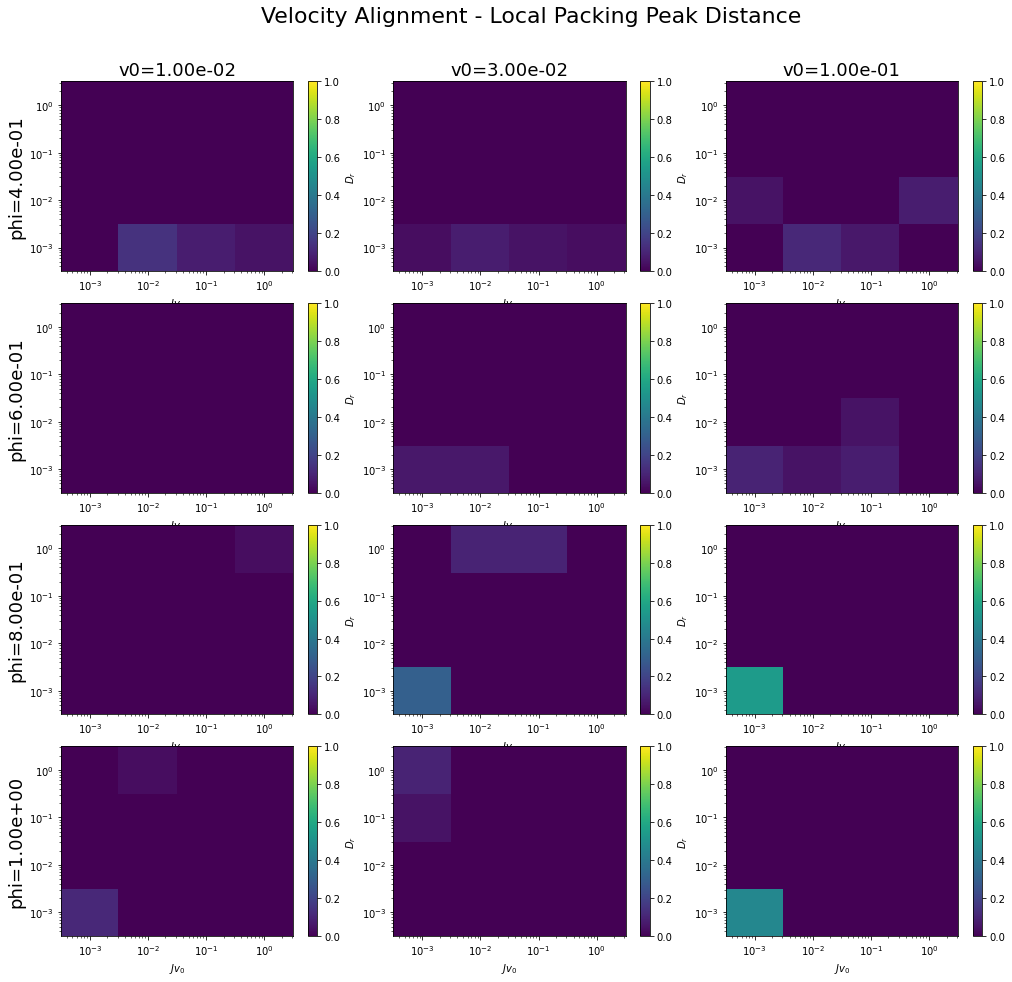

In [23]:
save_dir = "/home/ryanlopez/Velocity_Align_Vary_Phi_V_Saved_Data2"

fig, axs = plt.subplots(len(phi_vals), len(v0_vals), figsize=(14,14))
fig.tight_layout(rect=[0, 0.03, 1, 0.92])
fig.suptitle('Velocity Alignment - Local Packing Peak Distance', fontsize=22)
for v0_index, v0 in enumerate(v0_vals):
    for phi_index, phi in enumerate(phi_vals):
        #Load Data
        exp_folder_name = "phi=%.4f_and_v0=%.4f"%(phi, v0)
        exp_dir = os.path.join(save_dir, exp_folder_name)
        J_vals = np.array(Jv0_vals)/v0
        vicsek_vals = load_statistic_data('packing_peak_distance', Dr_vals, J_vals, exp_dir)

        #Make plot
        axs[phi_index, v0_index].set_xscale('log')
        axs[phi_index, v0_index].set_yscale('log')
        ax = axs[phi_index, v0_index].pcolormesh(xedges, yedges, vicsek_vals, vmin=0, vmax=1)
        plt.colorbar(ax, ax=axs[phi_index, v0_index])
        axs[phi_index, v0_index].set_xlabel(r'$Jv_0$')
        axs[phi_index, v0_index].set_ylabel(r'$D_r$')
        if phi_index == 0:
            axs[phi_index, v0_index].set_title(f'v0={v0:.2e}', fontsize=18)
        if v0_index == 0:
            axs[phi_index, v0_index].set_ylabel(f'phi={phi:.2e}', fontsize=18)
save_fig_pdf(os.path.join(save_dir, 'velocity_peak_distance_diagrams.pdf'))

# Calculate Peak Distance for All Simulations

In [17]:
def get_packing_dist_details(local_packing_fraction, box_length, num_bins_along_dim, particle_area):
    bin_area = (box_length/num_bins_along_dim)**2
    delta_packing_fraction = particle_area / bin_area
    #Each bin in hist corresponds to packing fraction from integer particles in local box
    bin_centers = delta_packing_fraction*np.arange(0, np.ceil(np.max(local_packing_fraction)/delta_packing_fraction)+1)
    bin_edges = edges_from_centers_linear(bin_centers)
    #Calculate histogram
    hist_values, _ = np.histogram(local_packing_fraction.flatten(), bins=bin_edges, density=True)
    peaks_indices, _ = find_peaks(hist_values, prominence=0.05)
    prominences, _, _ = peak_prominences(hist_values, peaks_indices)
    largest_peaks_indices = peaks_indices[np.argsort(-prominences)[:2]]
    return bin_edges , bin_centers, largest_peaks_indices

In [18]:
save_dir = "/home/ryanlopez/Velocity_Align_Vary_Phi_V_Saved_Data2"
for v0 in v0_vals:
    for phi in phi_vals:
        for Jv0 in Jv0_vals:
            for Dr in Dr_vals:
                J = Jv0 / v0
                exp_folder_name = "phi=%.4f_and_v0=%.4f"%(phi, v0)
                run_folder_name = "J=%.4f_and_Dr=%.4f"%(J, Dr)
                run_dir = os.path.join(save_dir, exp_folder_name, run_folder_name)
                snapshot_dir = os.path.join(run_dir, 'snapshot_data')
                run_desc_filename = os.path.join(run_dir, 'run_desc.json')
                single_stats_filename = os.path.join(run_dir, 'single_stats.json')
                new_single_stats_filename = os.path.join(run_dir, 'new_single_stats.json')

                #Load data
                with open(run_desc_filename, 'r') as run_desc_file:
                    run_desc = json.loads(run_desc_file.read())
                with open(single_stats_filename, 'r') as single_stats_file:
                    single_stats = json.loads(single_stats_file.read())
                box_length = run_desc['L']
                particle_area = np.pi*run_desc['radius']**2
                exp_data = rd.get_exp_data(snapshot_dir)

                #Calculate peak distance
                num_bins_along_dim = 5
                packing_fractions, _, _ = get_local_packing_fraction(exp_data, num_bins_along_dim, box_length, particle_area)
                bin_edges, bin_centers, largest_peaks_indices = get_packing_dist_details(packing_fractions, box_length, num_bins_along_dim, 
                                                                                particle_area)
                if len(largest_peaks_indices) == 1:
                    peak_distance = 0
                else:
                    peak_distance = np.abs(bin_centers[largest_peaks_indices[1]]-bin_centers[largest_peaks_indices[0]])

                #Save to new json file
                single_stats['packing_peak_distance'] = peak_distance
                with open(new_single_stats_filename, 'w') as new_single_stats_file:
                    new_single_stats_file.write(json.dumps(single_stats))
                print(f'Finished {os.path.join(exp_folder_name, run_folder_name)}')

Finished phi=0.4000_and_v0=0.0100/J=0.1000_and_Dr=0.0010
Finished phi=0.4000_and_v0=0.0100/J=0.1000_and_Dr=0.0100
Finished phi=0.4000_and_v0=0.0100/J=0.1000_and_Dr=0.1000
Finished phi=0.4000_and_v0=0.0100/J=0.1000_and_Dr=1.0000
Finished phi=0.4000_and_v0=0.0100/J=1.0000_and_Dr=0.0010
Finished phi=0.4000_and_v0=0.0100/J=1.0000_and_Dr=0.0100
Finished phi=0.4000_and_v0=0.0100/J=1.0000_and_Dr=0.1000
Finished phi=0.4000_and_v0=0.0100/J=1.0000_and_Dr=1.0000
Finished phi=0.4000_and_v0=0.0100/J=10.0000_and_Dr=0.0010
Finished phi=0.4000_and_v0=0.0100/J=10.0000_and_Dr=0.0100
Finished phi=0.4000_and_v0=0.0100/J=10.0000_and_Dr=0.1000
Finished phi=0.4000_and_v0=0.0100/J=10.0000_and_Dr=1.0000
Finished phi=0.4000_and_v0=0.0100/J=100.0000_and_Dr=0.0010
Finished phi=0.4000_and_v0=0.0100/J=100.0000_and_Dr=0.0100
Finished phi=0.4000_and_v0=0.0100/J=100.0000_and_Dr=0.1000
Finished phi=0.4000_and_v0=0.0100/J=100.0000_and_Dr=1.0000
Finished phi=0.6000_and_v0=0.0100/J=0.1000_and_Dr=0.0010
Finished phi=0.6000

Finished phi=0.6000_and_v0=0.1000/J=0.0100_and_Dr=1.0000
Finished phi=0.6000_and_v0=0.1000/J=0.1000_and_Dr=0.0010
Finished phi=0.6000_and_v0=0.1000/J=0.1000_and_Dr=0.0100
Finished phi=0.6000_and_v0=0.1000/J=0.1000_and_Dr=0.1000
Finished phi=0.6000_and_v0=0.1000/J=0.1000_and_Dr=1.0000
Finished phi=0.6000_and_v0=0.1000/J=1.0000_and_Dr=0.0010
Finished phi=0.6000_and_v0=0.1000/J=1.0000_and_Dr=0.0100
Finished phi=0.6000_and_v0=0.1000/J=1.0000_and_Dr=0.1000
Finished phi=0.6000_and_v0=0.1000/J=1.0000_and_Dr=1.0000
Finished phi=0.6000_and_v0=0.1000/J=10.0000_and_Dr=0.0010
Finished phi=0.6000_and_v0=0.1000/J=10.0000_and_Dr=0.0100
Finished phi=0.6000_and_v0=0.1000/J=10.0000_and_Dr=0.1000
Finished phi=0.6000_and_v0=0.1000/J=10.0000_and_Dr=1.0000
Finished phi=0.8000_and_v0=0.1000/J=0.0100_and_Dr=0.0010
Finished phi=0.8000_and_v0=0.1000/J=0.0100_and_Dr=0.0100
Finished phi=0.8000_and_v0=0.1000/J=0.0100_and_Dr=0.1000
Finished phi=0.8000_and_v0=0.1000/J=0.0100_and_Dr=1.0000
Finished phi=0.8000_and_v0=